In [3]:
import os,sys
import scipy 
import h5py as h5
import numpy as np
from galpy import potential,df
from galpy.orbit import Orbit
from astropy import units as u

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(path)

# Scripts
from AxionStreams import plot as pl
from AxionStreams import orbit as orb
from AxionStreams import density as dens

# Set units

kpc = u.kpc
kms = u.km/u.s
deg = u.deg
Gyr = u.Gyr

## Orbit creation from sampling 

In [43]:
# Alternative from halotools

# from halotools.empirical_models import NFWPhaseSpace

# nfw = NFWPhaseSpace()
# data = nfw.mc_generate_nfw_phase_space_points() 
# help(nfw.mc_generate_nfw_phase_space_points)

In [4]:
N_samples = 100
nframes   = 1000
T_Gyr     = 10
ts        = np.linspace(0.0,T_Gyr*u.Gyr,nframes)
tseries   = np.linspace(0.0,T_Gyr,nframes)

In [5]:
samples  = orb.orbit_sampling(N_samples)

In [6]:
%%time
Orbits   = orb.orbit_coordinates(samples,T_Gyr,nframes,ctype='Cartesian')

# Timeframe, coordinate, sample number 
# Coords[0,:,0]

CPU times: user 2.56 s, sys: 43.5 ms, total: 2.61 s
Wall time: 3.22 s


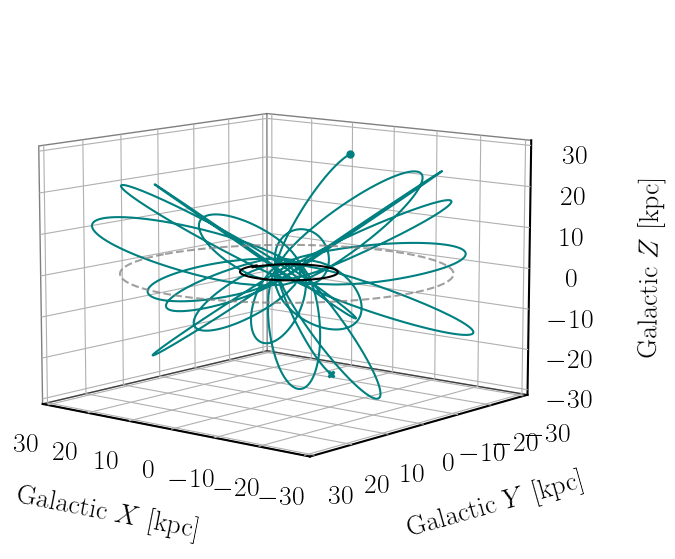

In [8]:
orbit_num = 1
pl.plot_single_orbit(Orbits[:,:,orbit_num],azim=10,sun=True,disk=True,lim=30,points=False,size_x=7,size_y=7)

In [9]:
# Count disk encouters
# help(orb.disk_encounters)

# Testing 
np.testing.assert_array_equal(orb.disk_encounters(Orbits,maxrad=0),orb.disk_encounters(Orbits))

# Example
enc = orb.disk_encounters(Orbits)
enc[:10]

array([  5,  29, 611,   7,  45,   4,   1,   7,   7,   4])

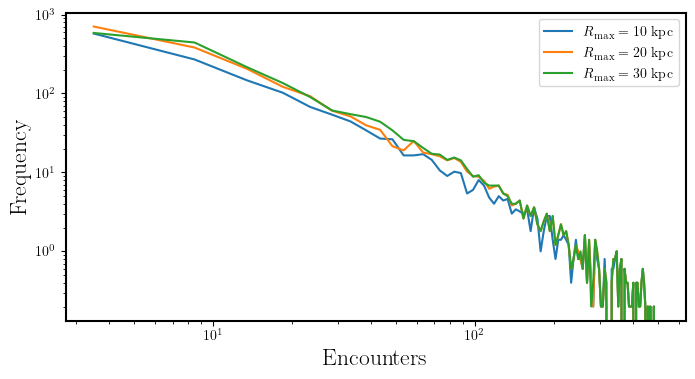

In [62]:
fig,ax = plt.subplots(figsize=(8,4))

for rad in [10,20,30]:
    enc = orb.disk_encounters(Orbits,maxrad=rad)
    dP,rb,_ = scipy.stats.binned_statistic(enc,enc,statistic='count',bins=100,range=[1,500]) 
    rc = (rb[0:-1]+rb[1:])/2
    dr = rb[1:]-rb[0:-1]
    prob = (dP/dr)
    ax.loglog(rc,prob,label=r'$R_{\rm max}=%d~{\rm kpc}$'%rad)
ax.set_xlabel('Encounters',fontsize=17)
ax.set_ylabel('Frequency',fontsize=17)
ax.legend()
plt.show()

In [67]:
rand_orbits = np.random.randint(N_samples,size=3)
rand_orbits

array([1996, 3725,  906])

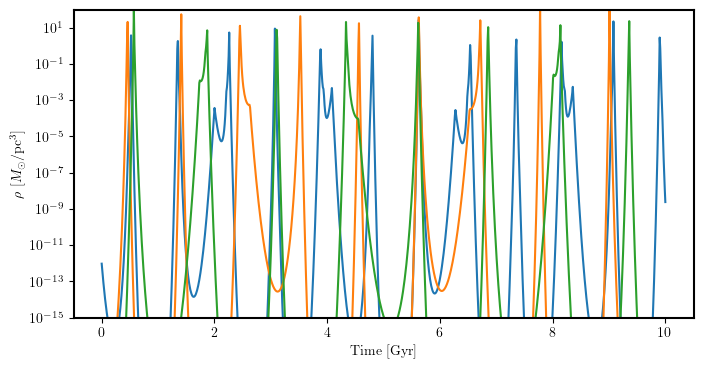

In [73]:
# Check now the stellar density 

fig,ax = plt.subplots(1,1,figsize=(8,4))

rand_orbits = np.random.randint(N_samples,size=3)

for j in rand_orbits:
    rho_test  = dens.stellar_density(Orbits[:,0,j],Orbits[:,1,j],Orbits[:,2,j])
    ax.semilogy(ts,rho_test)
ax.set_ylim(1e-15,1e2)
ax.set_xlabel('Time~[Gyr]')
ax.set_ylabel(r'$\rho~[M_{\odot}/{\rm pc}^3]$')
plt.show()

In [ ]:
# Define the number of encounters for each orbit



In [85]:
# Sample from the stellar density 
help(dens.sample_from_stellar_density)

Help on function sample_from_stellar_density in module AxionStreams.density:

sample_from_stellar_density(ts, Orbits, j, samplesize=100)
    Sample density values from the calculated stellar density
    Returns sampled timestamps and density values
    
    FIX: for now it onl takes a single orbit,
         there is an issue with time units (has to be dimensionless)



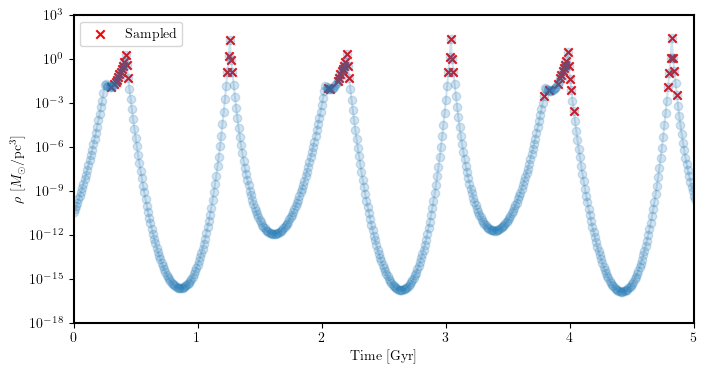

In [83]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
j = 10
rho_test  = dens.stellar_density(Orbits[:,0,j],Orbits[:,1,j],Orbits[:,2,j])
sam_ts,sam_rho = dens.sample_from_stellar_density(tseries,Orbits,j,samplesize=100)

ax.semilogy(ts,rho_test,marker='o',alpha=0.2)
ax.scatter(sam_ts,sam_rho,marker='x',c='r',label='Sampled')

ax.set_xlim(0,5)
ax.set_ylim(1e-18,1e3)
ax.set_xlabel('Time~[Gyr]')
ax.set_ylabel(r'$\rho~[M_{\odot}/{\rm pc}^3]$')
ax.legend()
plt.show()

## Density profiles from samples 

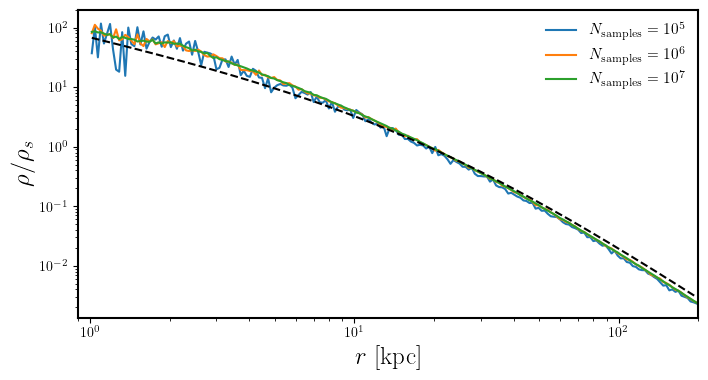

In [126]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

for ns in [1e5,1e6,1e7]:
    rc, rho = orb.get_profile(ns,bins=200,rmin=2,rmax=10000)
    ax.loglog(rc[rho!=0],rho[rho!=0],label=r'$N_{\rm samples}=10^{%d}$'%np.log10(ns))

rhoNFW = lambda x,rho0,Rs : rho0/((x/Rs)*(1+x/Rs)**2)
rho = rhoNFW(rc,1,19.0)
rho = rho/rhoNFW(19.0,1.0,19.0)
ax.loglog(rc,rho,c='k',ls='--')
ax.set_xlim(0.9,200)
ax.set_xlabel(r'$r~[{\rm kpc}]$',fontsize=18)
ax.set_ylabel(r'$\rho/\rho_s$',fontsize=18)
ax.legend(frameon=False,fontsize=11)
plt.show()

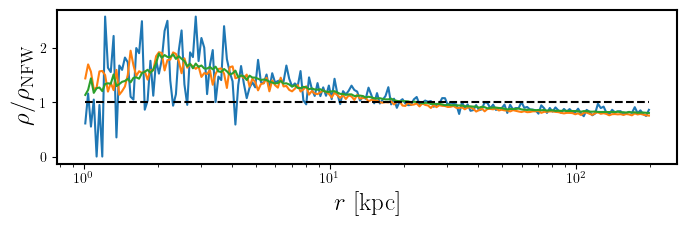

In [127]:
fig,ax = plt.subplots(1,1,figsize=(8,2))

#ns = 1e6
for ns in [1e5,1e6,1e7]:
    rc, rho = orb.get_profile(ns,bins=200,rmin=2,rmax=10000)
    rhoNFW = lambda x,rho0,Rs : rho0/((x/Rs)*(1+x/Rs)**2)
    rho2 = rhoNFW(rc,1,19.0)
    rho2 = rho2/rhoNFW(19.0,1.0,19.0)
    ax.semilogx(rc,rho/rho2)
ax.semilogx(rc,rho/rho,c='k',ls='--')
ax.set_xlabel(r'$r~[{\rm kpc}]$',fontsize=18)
ax.set_ylabel(r'$\rho/\rho_{\rm NFW}$',fontsize=18)
plt.show()

In [ ]:
# def NFW(r,r_s=19.4):
#     #rho_s = 0.43 # SolarMass/pc^3
#     rho_s = 1/(4*np.pi*r_s**3)
#     return rho_s/(r/r_s*(1+r/r_s)**2)

In [185]:
def dump_orbits(fname,N,T_Gyr,nframes):
    
    samples = orb.orbit_sampling(N,rmin=0.0,rmax=200)
    ts = np.linspace(0.0,T_Gyr,nframes)
    
    with h5.File('orbit_data/'+fname,'w') as f:
        f.create_dataset('TimeSeries',data=ts)
    
        for i in range(N):
            R   = samples[i].R()
            z   = samples[i].z()
            vR  = samples[i].vR()
            vT  = samples[i].vT()
            vz  = samples[i].vz()
            phi = samples[i].phi()*180/np.pi
            o = Orbit(vxvv=[R*kpc,vR*kms,vT*kms,z*kpc,vz*kms,phi*deg])
            o.integrate(ts,potential.MWPotential2014)

            fg = f.create_group('Orbit_%.3d'%i)
            fg.attrs['ID'] = i
            fg.create_dataset('x',data=o.x(ts))
            fg.create_dataset('y',data=o.y(ts))
            fg.create_dataset('z',data=o.z(ts))
            fg.create_dataset('vx',data=o.vx(ts))
            fg.create_dataset('vy',data=o.vy(ts))
            fg.create_dataset('vz',data=o.vz(ts))
            
# N = 1000
# T_Gyr = 13.5
# nframes = 1000

# dump_orbits('test_1000_01.hdf5',N,T_Gyr,nframes)

In [ ]:
# Stream Class

# Timeseries is common, so no need to add it 

# Inherit the 6D coordinates
# Inherit the ID

# Create Mass,Radius,alpha,beta (sampling functions)
# Create N_encounters (integration function)
# Create encounter timeseries (function,done)
# Create stellar_profile? 
# Create impact parameters series (sampling function)

# Stellar mass common at 1SolarMass for now

In [182]:
# Save orbits to hdf5


o = Orbit(vxvv=[8.0*kpc,100*kms,100*kms,1*kpc,50*kms,60*deg])
o.integrate(tseries,potential.MWPotential2014)
np.testing.assert_array_equal(o.t,tseries)
o.size

with h5.File('orbit_data/test.hdf5','w') as f:
    f.create_dataset('TimeSeries',data=tseries)
    for i in range(o.size):
        fg = f.create_group('Orbit_%.3d'%i)
        fg.create_dataset('x',data=o.x(tseries))
        fg.create_dataset('y',data=o.y(tseries))
        fg.create_dataset('z',data=o.z(tseries))
        fg.create_dataset('vx',data=o.vx(tseries))
        fg.create_dataset('vy',data=o.vy(tseries))
        fg.create_dataset('vz',data=o.vz(tseries))
        
        

#o.z(tseries[0])

In [169]:
# Save samples to txt/csv file 
# Initialisation of orbits from samples only 

# N_samples = int(1e6)

# pot  = potential.NFWPotential()
# distr_funct = df.isotropicNFWdf(pot=pot,rmax=10000*kpc,ro=8*kpc)#,rmax=200*kpc,vo=230*kms)#,ro=5*kpc)
# samples = distr_funct.sample(n=N_samples,return_orbit=False)
# R_i = samples[0]

In [171]:
# fig,ax = plt.subplots(1,1,figsize=(8,4))
# ax.loglog(rc,NFW(rc))
# ax.loglog(rc,rho)
# plt.show()

In [25]:
## Some attributes/methods of orbit class 
## samples can be replaced by any 'orbit' object

# Coordinates

# samples.r() # Spherical radius at time t
# samples.R() # Cylindrical radius at time t
# samples.theta()
# samples.x()
# samples.y()
# samples.z()

# # Velocities 

# samples.vx()
# samples.vy()
# samples.vz()
# samples.vphi() # Angular velocity

# # Time
# samples.time()

# Periods (needs to be integrated first)

# samples.Tr()
# samples.Tp()

#samples.dim()  # dimensions
#samples.dist() # return distance from the observer in kpc

# Integration 

# samples.integrate(t, pot, method='symplec4_c', progressbar=True, dt=None, numcores=2, force_map=False)

In [ ]:
# np= potential.NFWPotential(amp=1.2,a=2.3)
# #sam = sphericaldf.sample(R=None, z=None, phi=None, n=1, return_orbit=True, rmin=0.0)
# ndf= isotropicNFWdf(pot=np)
# # sample
# sam= ndf.sample(n=100)
# print(numpy.std(sam[numpy.fabs(sam.r()-1.2) < 0.1].vr()))
# # 0.2156787374302913
# # Compute vel. dispersion
# #print(ndf.sigmar(1.2))

In [ ]:
# from galpy.orbit import Orbit
# from galpy.potential import MWPotential2014
# import numpy
# import astropy.units as u
# ts= numpy.linspace(0.,1.,1001)*u.Gyr
# o = Orbit() 
# o.integrate(ts,MWPotential2014)
# o.plot()